# Accessing ITS_LIVE data via S3 bucket

This notebook will demonstrate how to access cloud-hosted Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) data from AWS S3 buckets. Here you will find examples of how to successfully access cloud-hosted data as well as some common errors and issues you may run into along the way, what they mean, and how to resolve them. 

Learning goals:
- accessing and inspecting data stored in s3 buckets 


Notes
- looks like some (at least 1?) HMA granule is working now
- let's try to explore the different 32645 granules, see what is available and what their spatial coverage/relationship is

In [2]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
#from geocube.api.core import make_geocube
from shapely.geometry import Polygon
import cartopy.crs as ccrs

import cartopy
import cartopy.feature as cfeature


## Function that we'll use later to see spatial extent of different zarr objects

In [3]:
def get_bbox(input_xr):

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    crs = 'epsg:32645'
    print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon = polygon.to_crs('epsg:4326')

    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(states_provinces)
    #data_cube_x25_y475.isel(mid_date=10).v.plot(ax=ax)

    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

    #extent = ax.get_extent()

    #ax.set_extent(extent, crs= ccrs.UTM(45, southern_hemisphere=False))
    polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)







In [4]:
def read_in_and_check_footprint(http_url):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True})
    if datacube != True:
        print('looks like file isnt there')
    else:
        get_bbox(datacube)

## Finding / selecting data

The ITS_LIVE project details a number of data access options on their [website](https://its-live.jpl.nasa.gov/#access). Here, we will be accessing ITS_LIVE data in the form of `zarr` data cubes that are stored in **s3 buckets** hosted by Amazon Web Services (AWS). 

Let's begin by looking at the [GeoJSON Data Cubes Catalog](https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json). 
This catalog contains spatial information and properties of ITS_LIVE data cubes as well as the url used to access each cube. Let's take a look at the entry for a single data cube and the information that it contains:

![itslive_info](images/screengrab_itslive_catalog_entry.png)

The top portion of the picture shows the spatial extent of the data cube in lat/lon units. Below that, we have properties such as the epsg code of the coordinate reference system, the spatial footprint in projected units and the url of the zarr object. 

Let's take a look at the url more in-depth: 

![itslive_url](images/itslive_url.png)

From this link we can see that we are looking at its_live data located in an s3 bucket hosted by amazon AWS. We cans see that we're looking in the data cube directory and what seems to be version 2. The next bit gives us information about the global location of the cube (N40E080). The actual file name `ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr` tells us that we are looking at ice velocity data (its_live also has elevation data), in the CRS associated with EPSG 32645 (this code indicates UTM zone 45N). X250000_Y4750000 tells us more about the spatial footprint of the datacube within the UTM zone (check that this is correct?). 

**NOTE**
This catalog provides http links to the zarr objects. To successfully point to the objects that we're looking for in s3 buckets, we need to make a few changes to the links:
- replace 'http' with 's3'
- delete '.s3.amazonaws.com' </br>

so the correct url should read: </br>

    `s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr`


## Accessing s3 data from python

Okay, so we've found the url associated with the tile we want to access, let's try to open the data cube using `xarray`

In [5]:
url_x25_y475 = 's3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr'
#data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine = 'zarr')

As you can see, this doesn't quite work. We need to specify a bit more information for xarray to be able to access and load the data cube:

In [6]:
data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine= 'zarr',
                                    storage_options = {'anon':True})

In [7]:
type(data_cube_x25_y475)

xarray.core.dataset.Dataset

{'init': 'epsg:32645'}


/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


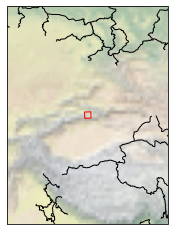

In [17]:
get_bbox(data_cube_x25_y475)

In [21]:
#this url doen'st work
#url_x35_y305 = 's3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3050000.zarr'
#data_cube_x35_y305 = xr.open_dataset(url_x35_y305, engine= 'zarr',
                                 #   storage_options = {'anon':True})


In [12]:
def read_in_and_check_footprint(http_url):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')
    print(s3_url)

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True})
    if type(datacube == 'xarray.core.dataset.Dataset'):

        print('looks like file isnt there')
         
    else:
        get_bbox(datacube)


In [10]:
def read_in_s3(http_url):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')
    print(s3_url)

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True})

    return datacube


s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4050000.zarr
epsg:32645


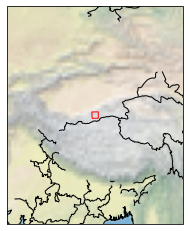

In [11]:
datacube_x35_y405 = read_in_s3('http://its-live-data.s3.amazonaws.com/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4050000.zarr')
get_bbox(datacube_x35_y405)

s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4150000.zarr
epsg:32645


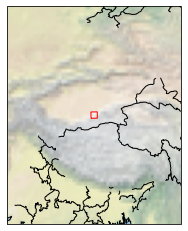

In [13]:
datacube_x35_y415 = read_in_s3('http://its-live-data.s3.amazonaws.com/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4150000.zarr')
get_bbox(datacube_x35_y415)

## TO DO NEXT!
- write something to parse this file, check which s3 urls work, see what data coverage is like ! 

https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json
^ s3 catalog 



s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3050000.zarr
epsg:32645


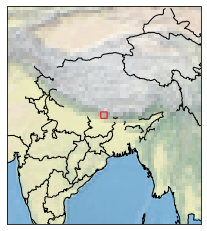

In [15]:
datacube_x45_y305 = read_in_s3('http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3050000.zarr')
get_bbox(datacube_x45_y305)

In [13]:
#urls that don't work
#read_in_and_check_footprint('http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3250000.zarr')
#read_in_and_check_footprint('http://its-live-data.s3.amazonaws.com/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3350000.zarr')
read_in_and_check_footprint('http://its-live-data.s3.amazonaws.com/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4050000.zarr')

s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4050000.zarr


In [22]:
#this url doens't work either
#url_x35_y315 = 's3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3150000.zarr'
#data_cube_x35_y315 = xr.open_dataset(url_x35_y315, engine = 'zarr',
#                                        storage_options = {'anon':True})

/var/folders/y9/k06gyzdx25z64l_tdt_q2xv9s680sz/T/ipykernel_23939/2080632588.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data_cube_x35_y315 = xr.open_dataset(url_x35_y315, engine = 'zarr',


GroupNotFoundError: group not found at path ''

In [51]:
data_cube_x25_y475.mapping.attrs['spatial_epsg']

data_cube_x25_y475 = data_cube_x25_y475.rio.write_crs(data_cube_x25_y475.mapping.attrs['spatial_epsg'])
data_cube_x25_y475.rio.crs

CRS.from_epsg(32645)

Let's take a look at the location of this data cube on the map:

In [14]:
def get_bbox(input_xr):

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    #crs = 'epsg:32645'
    print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon = polygon.to_crs('epsg:4326')

    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(states_provinces)
    #data_cube_x25_y475.isel(mid_date=10).v.plot(ax=ax)

    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

    #extent = ax.get_extent()

    #ax.set_extent(extent, crs= ccrs.UTM(45, southern_hemisphere=False))
    polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)






epsg:32645
epsg:4326
[68.30309538988925, 99.56800219238056, 27.394272955507645, 58.325756081461115]


/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


<GeoAxesSubplot:>

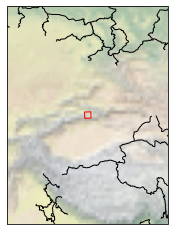

In [13]:
def get_bbox(input_xr):

xmin = data_cube_x25_y475.coords['x'].data.min()
xmax = data_cube_x25_y475.coords['x'].data.max()

ymin = data_cube_x25_y475.coords['y'].data.min()
ymax = data_cube_x25_y475.coords['y'].data.max()

pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

#crs = {'init':f'epsg:{data_cube_x25_y475.mapping.spatial_epsg}'}
crs = 'epsg:32645'
print(crs)
polygon_geom = Polygon(pts_ls)
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])  

polygon = polygon.to_crs('epsg:4326')
print(polygon.crs)

bounds = polygon.total_bounds
bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]
#bounds_format = [-250000.0, 1250000.0, -10000000.0, 25000000.0]
print(bounds_format)

states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
)

fig = plt.figure()
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(states_provinces)
#data_cube_x25_y475.isel(mid_date=10).v.plot(ax=ax)

ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

#extent = ax.get_extent()

#ax.set_extent(extent, crs= ccrs.UTM(45, southern_hemisphere=False))
polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)


In [ ]:
def get_bbox(input_xr):
    ''' Takes an xarray object (meant to be an its_live velocity xr object) and returns a polygon with the bbox as well as a plot. 
        Meant to be useful for quickly visualizing the spatial extent of an its_live object accessed from s3 bucket'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = {f'epsg:{input_xr.mapping.spatial_epsg}'}
    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])  

    fig, ax = plt.subplots()
    ax = plt.axes(projection=ccrs.UTM(zone = 45, southern_hemisphere=False))
    input_xr.v.plot(ax=ax)
    polygon.plot(ax=ax, facecolor='none', edgecolor='red') 


    #class cartopy.crs.UTM(zone, southern_hemisphere=False, globe=None)

    return polygon    

/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,"POLYGON ((200092.500 4699987.500, 299932.500 4..."


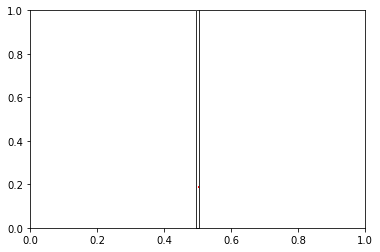

In [9]:
get_bbox(data_cube_x25_y475)

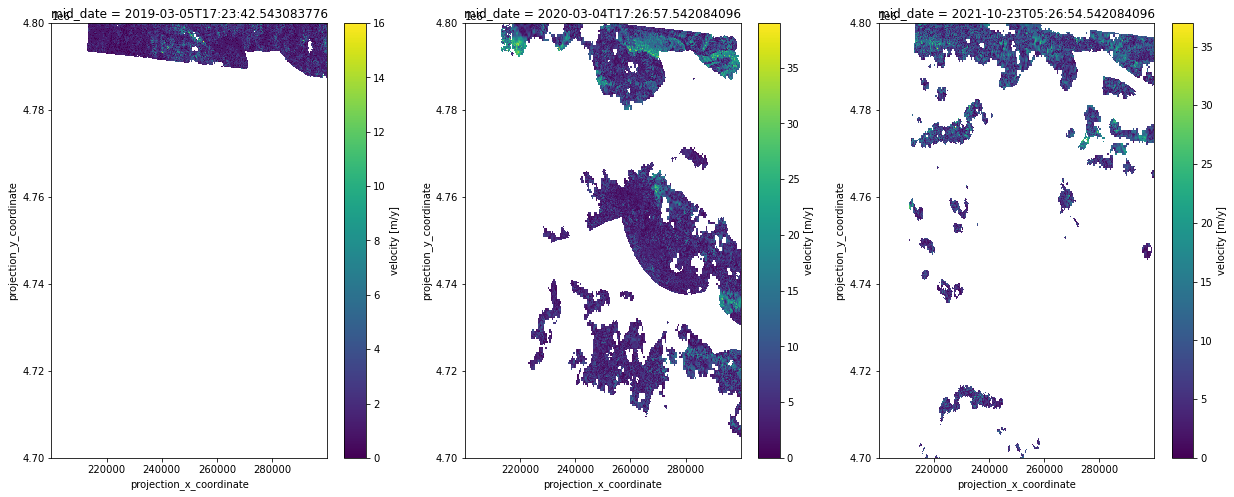

In [7]:
fig, axs = plt.subplots(ncols = 3, figsize=(21,8))
data_cube_x25_y475.isel(mid_date=1).v.plot(ax=axs[0])
data_cube_x25_y475.isel(mid_date=2).v.plot(ax=axs[1])
data_cube_x25_y475.isel(mid_date=3).v.plot(ax=axs[2])



Taking an initial look at a few different time steps, it looks like there is pretty variable coverage. Let's explore the variability in coverage a bit more:

Nice! This worked, let's explore the data object a bit

In [3]:
zarr_32645_x350000_y3050000 = 's3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3050000.zarr'

ds_32645_x350000_y3050000 = xr.open_dataset(zarr_32645_x350000_y3050000, engine = 'zarr',
                            storage_options= {'anon':True})

/var/folders/y9/k06gyzdx25z64l_tdt_q2xv9s680sz/T/ipykernel_17703/2145342222.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_32645_x350000_y3050000 = xr.open_dataset(zarr_32645_x350000_y3050000, engine = 'zarr',


GroupNotFoundError: group not found at path ''

Dang, doesn't look like it's there

Trying with another url for the same region:

In [4]:
zarr_32645_x350000_y4650000 = "s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4650000.zarr"

ds_32645_x350000_y4650000 = xr.open_dataset(zarr_32645_x350000_y4650000, engine = 'zarr',
                            storage_options={'anon':True})

Cool! This one worked, let's see the bounding box

In [14]:
bbox_x350000_y4650000 = get_bbox(ds_32645_x350000_y4650000)

/Users/emarshall/miniconda3/envs/mynewbook/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


: 

: 